<a href="https://colab.research.google.com/github/jihoahn9303/Back_Propagation/blob/main/BDA714_00_Lab08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Session \# 08


---


by Josué Obregón <br>
BDA714-00 - Data Mining <br>
Department of Big Data Analytics - Kyung Hee University<br>


## Objectives

The objective of this worksheet is to introduce the student to clustering techniques with python.

## Importing libraries 


The libraries we'll import to start with are pandas and numpy for data handling, and matplotlib, seaborn, and plotly for display generation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
sns.set_style("darkgrid")

# Synthetic dataset generation

In [3]:
import time
import warnings

In [4]:
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from scipy.cluster import hierarchy


In [5]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    hierarchy.dendrogram(linkage_matrix, **kwargs)

Generate datasets. We choose the size big enough to see the scalability of the algorithms, but not too big to avoid too long running times

In [6]:

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data (data having different properties in different directions)
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============




default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets_ = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.08,
            "name":'Noisy circles'
        },
    ),
    (
        noisy_moons,
        {
            "damping": 0.75,
            "preference": -220,
            "n_clusters": 2,
            "min_samples": 7,
            "xi": 0.1,
         "name":'Noisy moons'
        },
    ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
         "name":'Blobs with varied variances'
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.1,
            "min_cluster_size": 0.2,
         "name":'Anisotropicly distributed'
        },
    ),
    (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2,"name":'Blobs'}),
    (no_structure, {"name":'No structure'}),
]

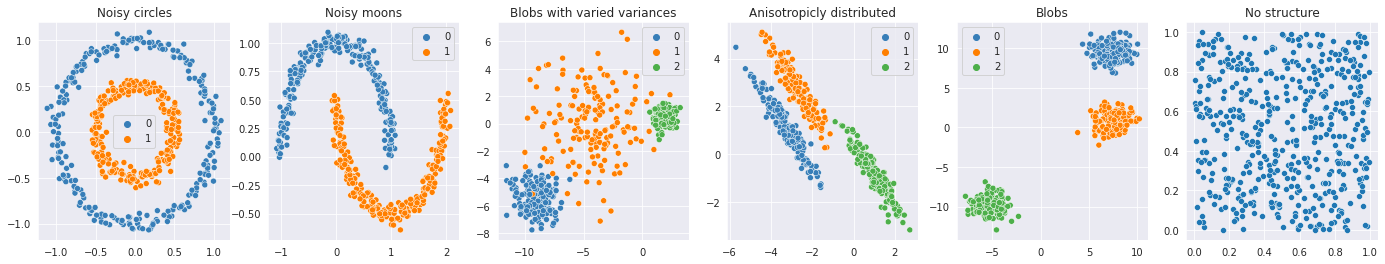

In [7]:
fig, axes = plt.subplots(ncols=len(datasets_),figsize=(4*len(datasets_),4))
palette = [ "#377eb8", "#ff7f00", "#4daf4a", "#f781bf" ]
for i_dataset, (ds, algo_params) in enumerate(datasets_):
  params = default_base.copy()
  params.update(algo_params)
  X, y = ds
  sns.scatterplot(x=X[:,0],y=X[:,1],hue=y, palette=palette[:params["n_clusters"]],ax=axes[i_dataset])
  axes[i_dataset].set_title(params['name'])

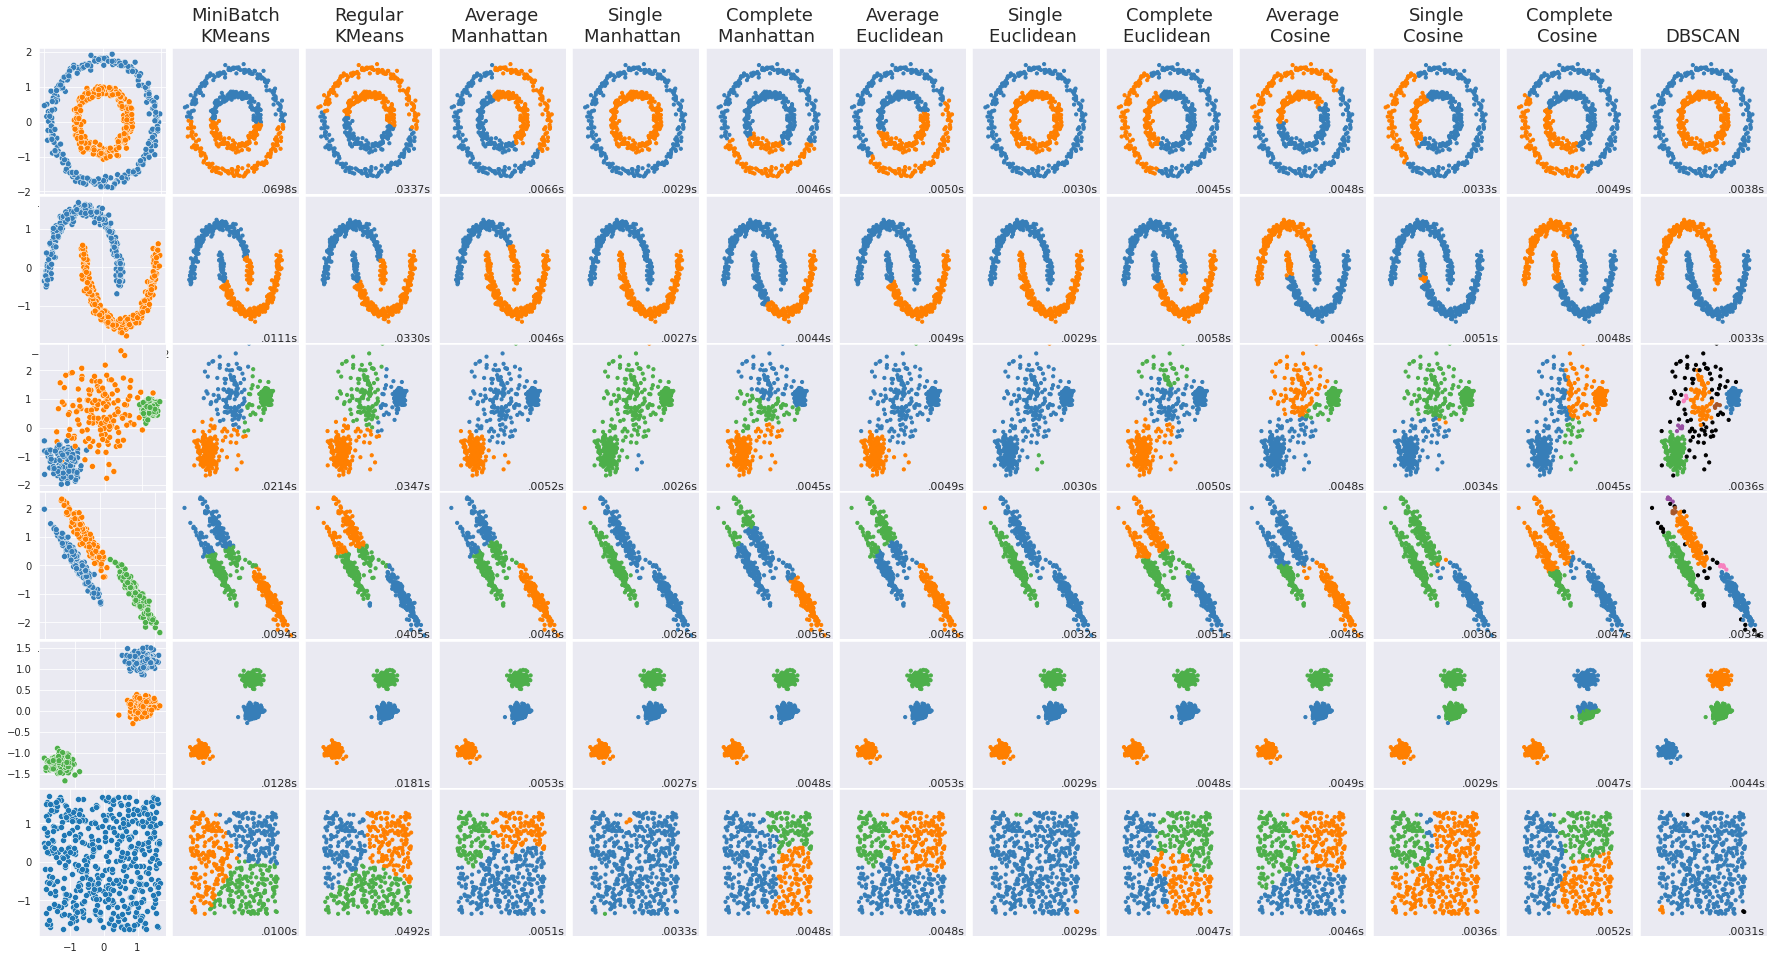

In [8]:
plt.figure(figsize=(11 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets_):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

   
    # ============
    # Create cluster objects
    # ============
    
    min_batchkmeans = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    regulark_means = cluster.KMeans(n_clusters=params["n_clusters"])
    
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="manhattan",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    single_linkage = cluster.AgglomerativeClustering(
        linkage="single",
        affinity="manhattan",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )
    complete_linkage = cluster.AgglomerativeClustering(
        linkage="complete",
        affinity="manhattan",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    average_linkage_e = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    single_linkage_e = cluster.AgglomerativeClustering(
        linkage="single",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )
    complete_linkage_e = cluster.AgglomerativeClustering(
        linkage="complete",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    average_linkage_c = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cosine",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    single_linkage_c = cluster.AgglomerativeClustering(
        linkage="single",
        affinity="cosine",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )
    complete_linkage_c = cluster.AgglomerativeClustering(
        linkage="complete",
        affinity="cosine",
        n_clusters=params["n_clusters"],
        #connectivity=connectivity,
    )

    dbscan = cluster.DBSCAN(eps=params["eps"])
    

    clustering_algorithms = (
        ("Grand truth",None),
        ("MiniBatch\nKMeans", min_batchkmeans),
        ("Regular\nKMeans", regulark_means),
        ("Average\nManhattan ", average_linkage),
        ("Single\nManhattan ", single_linkage),
        ("Complete\nManhattan ", complete_linkage),
        ("Average\nEuclidean ", average_linkage_e),
        ("Single\nEuclidean ", single_linkage_e),
        ("Complete\nEuclidean ", complete_linkage_e),
        ("Average\nCosine ", average_linkage_c),
        ("Single\nCosine ", single_linkage_c),
        ("Complete\nCosine ", complete_linkage_c),
        ("DBSCAN", dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        if name!='Grand truth':            
          # catch warnings related to kneighbors_graph
          with warnings.catch_warnings():
              warnings.filterwarnings(
                  "ignore",
                  message="the number of connected components of the "
                  + "connectivity matrix is [0-9]{1,2}"
                  + " > 1. Completing it to avoid stopping the tree early.",
                  category=UserWarning,
              )
              warnings.filterwarnings(
                  "ignore",
                  message="Graph is not fully connected, spectral embedding"
                  + " may not work as expected.",
                  category=UserWarning,
              )
              algorithm.fit(X)

              t1 = time.time()
              if hasattr(algorithm, "labels_"):
                  y_pred = algorithm.labels_.astype(int)
              else:
                  y_pred = algorithm.predict(X)
          

          plt.subplot(len(datasets_), len(clustering_algorithms), plot_num)
          if i_dataset == 0:
            plt.title(name, size=18)

            
          palette = [
                                "#377eb8",
                                "#ff7f00",
                                "#4daf4a",
                                "#f781bf",
                                "#a65628",
                                "#984ea3",
                                "#999999",
                                "#e41a1c",
                                "#dede00",
                            ]
          colors = np.array(
                list(
                    islice(
                        cycle(
                            palette
                        ),
                        int(max(y_pred) + 1),
                    )
                )
            )        
            # add black color for outliers (if any)
          colors = np.append(colors, ["#000000"])
        if name=='Grand truth':
          plt.subplot(len(datasets_), len(clustering_algorithms), plot_num)
          sns.scatterplot(x=X[:,0],y=X[:,1],hue=y, palette=palette[:params["n_clusters"]],legend=False)
        else:
          plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

          plt.xlim(-2.5, 2.5)
          plt.ylim(-2.5, 2.5)
          plt.xticks(())
          plt.yticks(())
          plt.text(
              0.99,
              0.01,
              ("%.4fs" % (t1 - t0)).lstrip("0"),
              transform=plt.gca().transAxes,
              size=11,
              horizontalalignment="right",
          )
        plot_num += 1

plt.show()

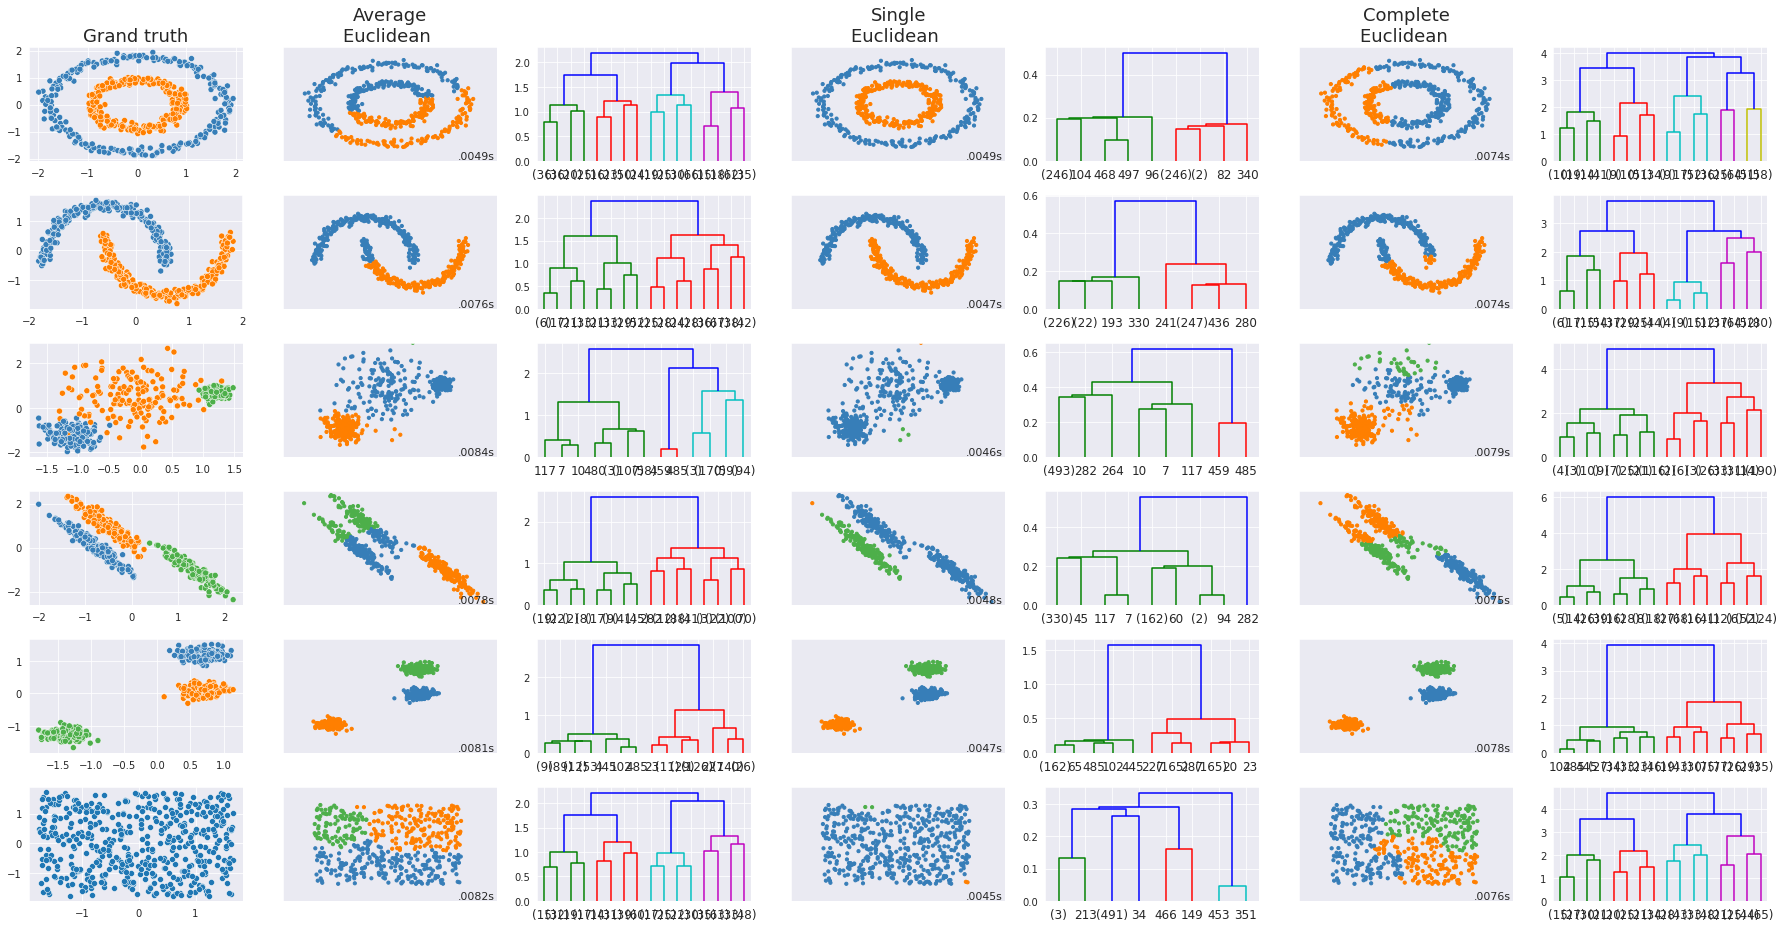

In [9]:
plt.figure(figsize=(11 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plot_num = 1
for i_dataset, (dataset, algo_params) in enumerate(datasets_):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

   
    # ============
    # Create cluster objects
    # ============
    
    average_linkage_e =   cluster.AgglomerativeClustering(
        linkage="average",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        compute_distances=True
        #connectivity=connectivity,
    )

    single_linkage_e = cluster.AgglomerativeClustering(
        linkage="single",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        compute_distances=True
        #connectivity=connectivity,
    )
    complete_linkage_e = cluster.AgglomerativeClustering(
        linkage="complete",
        affinity="euclidean",
        n_clusters=params["n_clusters"],
        compute_distances=True
        #connectivity=connectivity,
    )

   
    clustering_algorithms = (
        ("Grand truth",None),        
        ("Average\nEuclidean ", average_linkage_e),
        ("Single\nEuclidean ", single_linkage_e),
        ("Complete\nEuclidean ", complete_linkage_e),
       
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        linkage=None
        if name!='Grand truth':            
          # catch warnings related to kneighbors_graph
          with warnings.catch_warnings():
              warnings.filterwarnings(
                  "ignore",
                  message="the number of connected components of the "
                  + "connectivity matrix is [0-9]{1,2}"
                  + " > 1. Completing it to avoid stopping the tree early.",
                  category=UserWarning,
              )
              warnings.filterwarnings(
                  "ignore",
                  message="Graph is not fully connected, spectral embedding"
                  + " may not work as expected.",
                  category=UserWarning,
              )
              model = algorithm.fit(X)
              # if 'Average' in name:
              #   linkage = hierarchy.average(X)
              # elif 'Single' in name:
              #   linkage = hierarchy.single(X)
              # else:
              #   linkage = hierarchy.complete(X)

          t1 = time.time()
          if hasattr(algorithm, "labels_"):
              y_pred = algorithm.labels_.astype(int)
          else:
              y_pred = algorithm.predict(X)

        plt.subplot(len(datasets_), len(clustering_algorithms)+3, plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        
        palette = [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
        colors = np.array(
            list(
                islice(
                    cycle(
                        palette
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )        
        if name=='Grand truth':
          sns.scatterplot(x=X[:,0],y=X[:,1],hue=y, palette=palette[:params["n_clusters"]],legend=False)
        else:
          plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

          plt.xlim(-2.5, 2.5)
          plt.ylim(-2.5, 2.5)
          plt.xticks(())
          plt.yticks(())
          plt.text(
              0.99,
              0.01,
              ("%.4fs" % (t1 - t0)).lstrip("0"),
              transform=plt.gca().transAxes,
              size=11,
              horizontalalignment="right",
          )
          plt.subplot(len(datasets_), len(clustering_algorithms)+3, plot_num +1 )
          
          
          plot_dendrogram(model, truncate_mode="level", p=3)
          plot_num += 1
        plot_num += 1

plt.tight_layout()
plt.show()

## Simpler example

In [10]:
# Generate data
np.random.seed(2)
X = np.random.standard_normal((50,2))
X[:25,0] = X[:25,0]+3
X[:25,1] = X[:25,1]-4

K=2

In [11]:
km1 = cluster.KMeans(n_clusters=2, n_init=20)
km1.fit(X)

KMeans(n_clusters=2, n_init=20)

In [12]:
km1.labels_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1], dtype=int32)

K=3

In [13]:
np.random.seed(4)
km2 = cluster.KMeans(n_clusters=3, n_init=20)
km2.fit(X)

KMeans(n_clusters=3, n_init=20)

In [14]:
km2.cluster_centers_

array([[-0.27876523,  0.51224152],
       [ 2.82805911, -4.11351797],
       [ 0.69945422, -2.14934345]])

In [15]:
km2.labels_

array([1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       0, 0, 0, 0, 0, 2], dtype=int32)

In [16]:
# Sum of distances of samples to their closest cluster center.
km2.inertia_

68.97379200939723

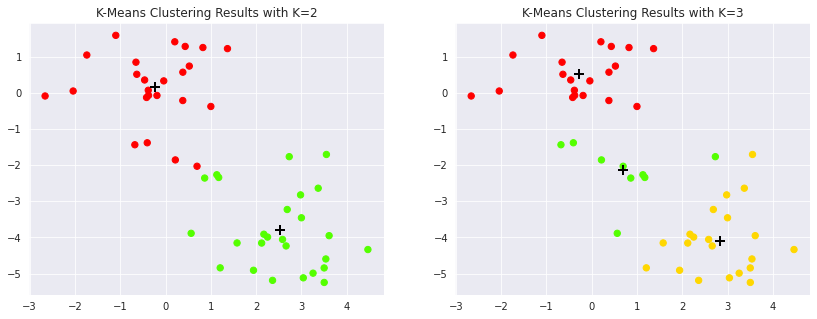

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

ax1.scatter(X[:,0], X[:,1], s=40, c=km1.labels_, cmap=plt.cm.prism) 
ax1.set_title('K-Means Clustering Results with K=2')
ax1.scatter(km1.cluster_centers_[:,0], km1.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2)

ax2.scatter(X[:,0], X[:,1], s=40, c=km2.labels_, cmap=plt.cm.prism) 
ax2.set_title('K-Means Clustering Results with K=3')
ax2.scatter(km2.cluster_centers_[:,0], km2.cluster_centers_[:,1], marker='+', s=100, c='k', linewidth=2);

## hierarchical clustering using scipy

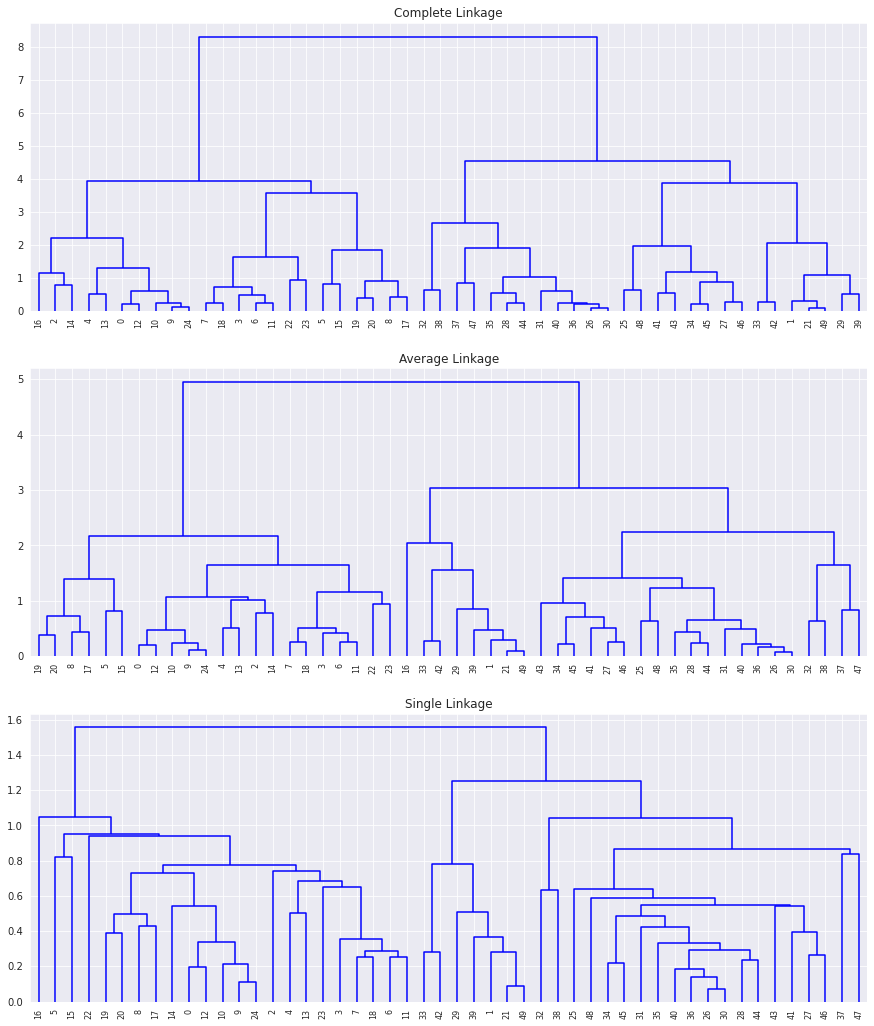

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,18))

for linkage, cluster_, ax in zip([hierarchy.complete(X), hierarchy.average(X), hierarchy.single(X)], ['c1','c2','c3'],
                                [ax1,ax2,ax3]):
    cluster_ = hierarchy.dendrogram(linkage, ax=ax, color_threshold=0)

ax1.set_title('Complete Linkage')
ax2.set_title('Average Linkage')
ax3.set_title('Single Linkage');